## Loading data

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import json
import pickle
import glob
import itertools
import pandas as pd
from utils.plot_util import *
import socket
import os
from pathlib import Path


In [3]:
import tensorflow as tf

# set up gpu to make sure one gpu can work for multiple scripts at the same time
os.environ["CUDA_VISIBLE_DEVICES"]="1" # use the second gpu
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


In [4]:
hostname = socket.gethostname()
if hostname == 'HAITI' or 'Gorleben':
    DIR = "C:/Users/xin/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "D:/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'BALI':
    DIR = "/home/xin/projects/trelleborg"
    DATASET = "/storage/xin/datasets/Trelleborg/V27/*.h5"
if hostname == 'LAPTOP-1FOJITEG':
    DIR = "C:/Users/xinch/OneDrive - bwstaff/xin/trelleborg"
    DATASET = "C:/LINHC/VersucheDBs/Trelleborg/V27/*.h5"
DIR = os.path.abspath(DIR)
DATASET = os.path.abspath(DATASET)

file_list = []
for file in glob.glob(DATASET):
    file_list.append(file)
file_list = sorted(file_list)
file_list_LEM1 = [file for file in file_list if 'LEM1' in file]
file_list_LEM1

['D:\\xin\\datasets\\Trelleborg\\V27\\V27-100bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-200bar_LEM1.h5',
 'D:\\xin\\datasets\\Trelleborg\\V27\\V27-30bar_LEM1.h5']

file: V27-100bar_LEM1

ATTR:
<KeysViewHDF5 ['name_lookup', 'name_rev_lookup']>

Keys:
<KeysViewHDF5 ['S11_LEM1', 'S21_P1_LEM1', 'S21_P2_LEM1', 'S22_LEM1', 'hub1', 'hub2', 'ip1k1', 'ip1k2', 'ip2k1', 'ip2k2', 'k1at', 'k1f', 'k1p', 'k1t', 'k2at', 'k2f', 'k2p', 'k2t', 'phi', 'pos1', 'pos2', 'shub1', 'shub2', 'sk1at', 'sk1f', 'sk1p', 'sk1t', 'sk2at', 'sk2f', 'sk2p', 'sk2t', 'spd1', 'spd2', 'sphi', 'spos1', 'spos2', 'sspd1', 'sspd2', 'stdf', 't', 'tdf']>

Points:
(419301,)

shift_opts_freqs_all:
(121, 419301)



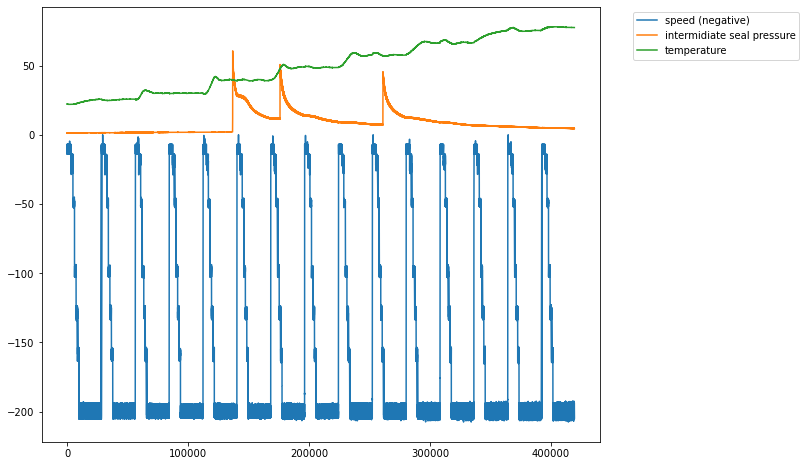

In [5]:
num = 0  # TODO
file = file_list_LEM1[num]
filename = file.split(os.sep)[-1][:-3]
pklName = DIR + '/data/V27/shift_opts_freqs_all/' + filename + '.pkl'
shift_opts_freqs_all = pickle.load(open(pklName, 'rb')) 
h51 = h5py.File(file, "r")
print("file:",filename)
print("\nATTR:")
print(h51.attrs.keys())
print("\nKeys:")
print(h51.keys())
print("\nPoints:")
print(h51['t'].shape)
print("\nshift_opts_freqs_all:")
print(shift_opts_freqs_all.shape)
print()

#     # print look up dictionary
#     json_object = json.loads(h51.attrs["name_lookup"])
#     json_formatted_str = json.dumps(json_object, indent=2)
#     print("\nLOOKUP:")
#     print(json_formatted_str)

# plot of speed, isp and temperature
fidx = 20
%matplotlib inline
plt.figure(figsize=(10,8))
plt.plot(h51['spd1'],label='speed (negative)')
plt.plot(h51['ip1k1'],label='intermidiate seal pressure')
plt.plot(h51['k1t'],label='temperature')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')


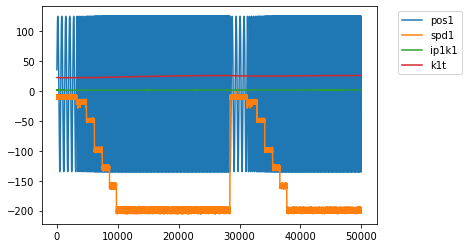

In [6]:
GT = ['pos1','spd1','ip1k1','k1t']
for gt in GT:
    plt.plot(h51[gt][:50000], label = gt)
plt.legend(bbox_to_anchor=(1.05, 1))

In [7]:
low = np.where(h51['spd1'][:]>-40)[0]
pos_low = h51['pos1'][low]
low_sep = np.where(np.diff(low)>3000)[0] # check if 3000 fit for all datasets
pos_low_sep = np.split(pos_low,low_sep+1)
Ls = np.append(low[low_sep],low[-1])
print("timestamps of Ls:")
print (Ls)

Fs = np.append(low[0],low[low_sep+1])
print("timestamps of Fs:")
print (Fs)

print("Durations of lsa:\n",Ls-Fs)

timestamps of Ls:
[  4854  32841  60824  88812 116796 144781 172768 200753 228737 256726
 284716 312700 340692 368681 396669]
timestamps of Fs:
[     0  28449  56436  84419 112406 140390 168375 196362 224348 252332
 280320 308310 336295 364285 392274]
Durations of lsa:
 [4854 4392 4388 4393 4390 4391 4393 4391 4389 4394 4396 4390 4397 4396
 4395]


In [28]:
# set up model saving folder
if num == 0:
    SAVED_IN = DIR + "/models/V27/100bar/"
if num == 1:
    SAVED_IN = DIR + "/models/V27/200bar/"
if num == 2:
    SAVED_IN = DIR + "/models/V27/30bar/"
    
SAVED_IN = os.path.abspath(SAVED_IN)
Path(SAVED_IN).mkdir(parents=True, exist_ok=True)


In [9]:
N = 100 # ignore first N points
s21 = np.array(h51['S21_P1_LEM1'])
dataset = []
for j in range (121):
    index = np.arange(N,len(h51['t'])) - shift_opts_freqs_all[j,N:].round().astype(int)
    dataset.append(s21[index,j].real)
    dataset.append(s21[index,j].imag)
    
X = np.asarray(dataset).T
y = np.vstack(
    (
        np.asarray(h51['pos1'][N:]),
        np.asarray(h51['spd1'][N:]),
        np.asarray(h51['ip1k1'][N:]),
        np.asarray(h51['k1t'][N:])
    )
)
y = y.T
print("X:")
print(X.shape)
print("y:")
print(y.shape)

X:
(419201, 242)
y:
(419201, 4)


In [10]:
h51.close()

## Preprocessing

In [11]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, indices, test_size=0.2, random_state=42)
idx_train_sort = np.sort(idx_train)
idx_test_sort = np.sort(idx_test)

# indices2 = np.arange(X_train.shape[0])
# X_train2, X_val, y_train2, y_val, idx_train2, idx_val = train_test_split(X_train, y_train, indices2, test_size=0.125, random_state=42) # 0.125 x 0.8 = 0.1

print(X_train.shape)
print(X_test.shape)

(335360, 242)
(83841, 242)


In [11]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
# scaler.mean_.shape

In [12]:
# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_train))
# test_dataset = tf.data.Dataset.from_tensor_slices((X_test_scaled, y_test))
# val_dataset = tf.data.Dataset.from_tensor_slices((X_val_scaled, y_val))

# BATCH_SIZE = 64

# train_dataset = train_dataset.batch(BATCH_SIZE)
# test_dataset = test_dataset.batch(BATCH_SIZE)
# val_dataset = val_dataset.batch(BATCH_SIZE)

## Hyperparameter fine-tuning

In [13]:
# def baseline_model():
#   model = keras.Sequential([
#       layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
#       layers.Dense(64, kernel_initializer='normal',activation='relu'),
#       layers.Dense(4,activation='linear')
#   ])

#   model.compile(loss='mean_squared_error',
#                 optimizer=tf.keras.optimizers.Adam(0.001))
#   return model

In [14]:
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold

# # evaluate model
# estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=64, verbose=0)
# kfold = KFold(n_splits=3)
# results = cross_val_score(estimator, X_val_scaled, y_val, cv=kfold)
# print("Baseline: %.2f (%.2f) MSE" % (abs(results.mean()), results.std()))

## Training

### Baseline model with normalization

In [15]:
MODEL_NAME = "NN_baseline_combi"

In [16]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [17]:
def baseline_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(128, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(64, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [18]:
NN_baseline = baseline_model(normalizer)
NN_baseline.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization (Normalization (None, 242)               485       
_________________________________________________________________
dense (Dense)                (None, 128)               31104     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 260       
Total params: 40,105
Trainable params: 39,620
Non-trainable params: 485
_________________________________________________________________


In [19]:
%%time
history = NN_baseline.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=0, epochs=100)

Wall time: 9min 7s


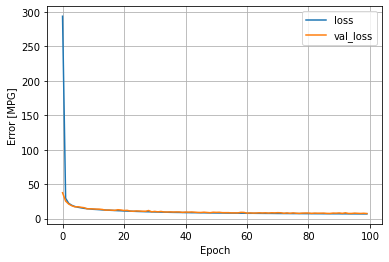

In [20]:
plot_loss(history)

In [21]:
NN_baseline.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barNN_baseline_combi\assets


In [22]:
# MODEL_NAME = "NN_baseline_combi" 
# NN_baseline = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [23]:
# evaluation on both training and test sets

y_ = NN_baseline.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [24]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,2.253358,2.350895
1,spd1,11.533517,13.332422
2,ip1k1,9.744029,10.474224
3,k1t,2.949772,3.134626


In [26]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  6.620169069647267
MSE of the prediction on test set:  7.323041846015861


In [25]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
y_train_lsa_ = y_[idx_com_train]
y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(y[idx_com_train] - y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,1.241352,1.453616
1,spd1,16.554053,19.670808
2,ip1k1,7.271116,7.252204
3,k1t,3.532561,3.903958


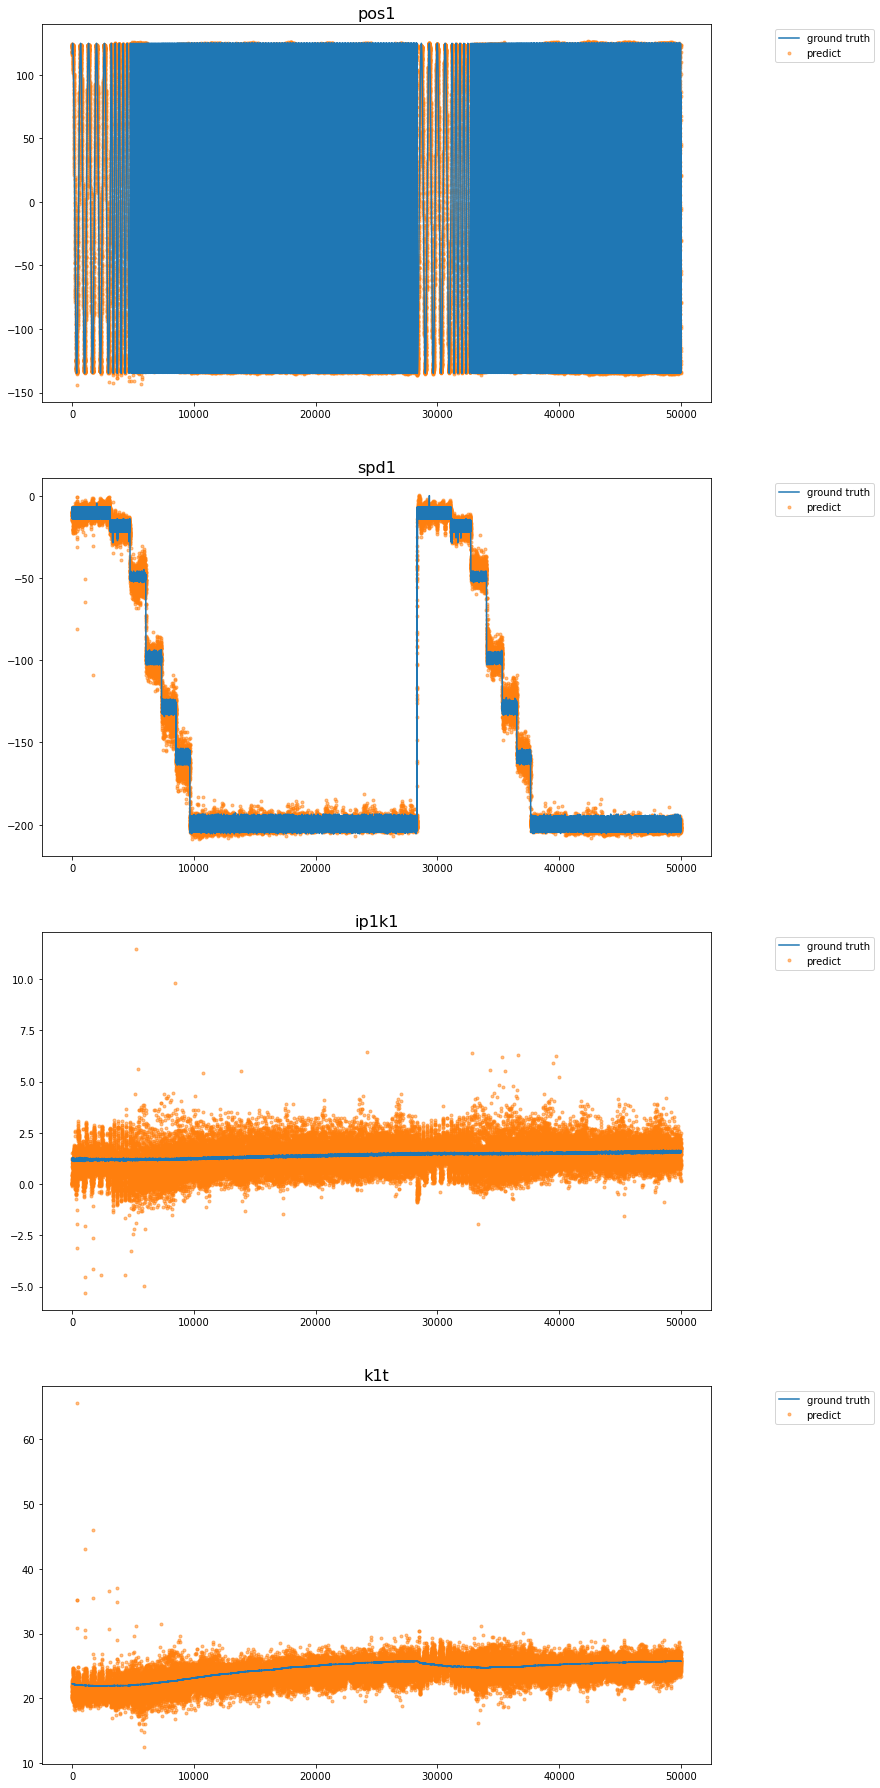

In [27]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

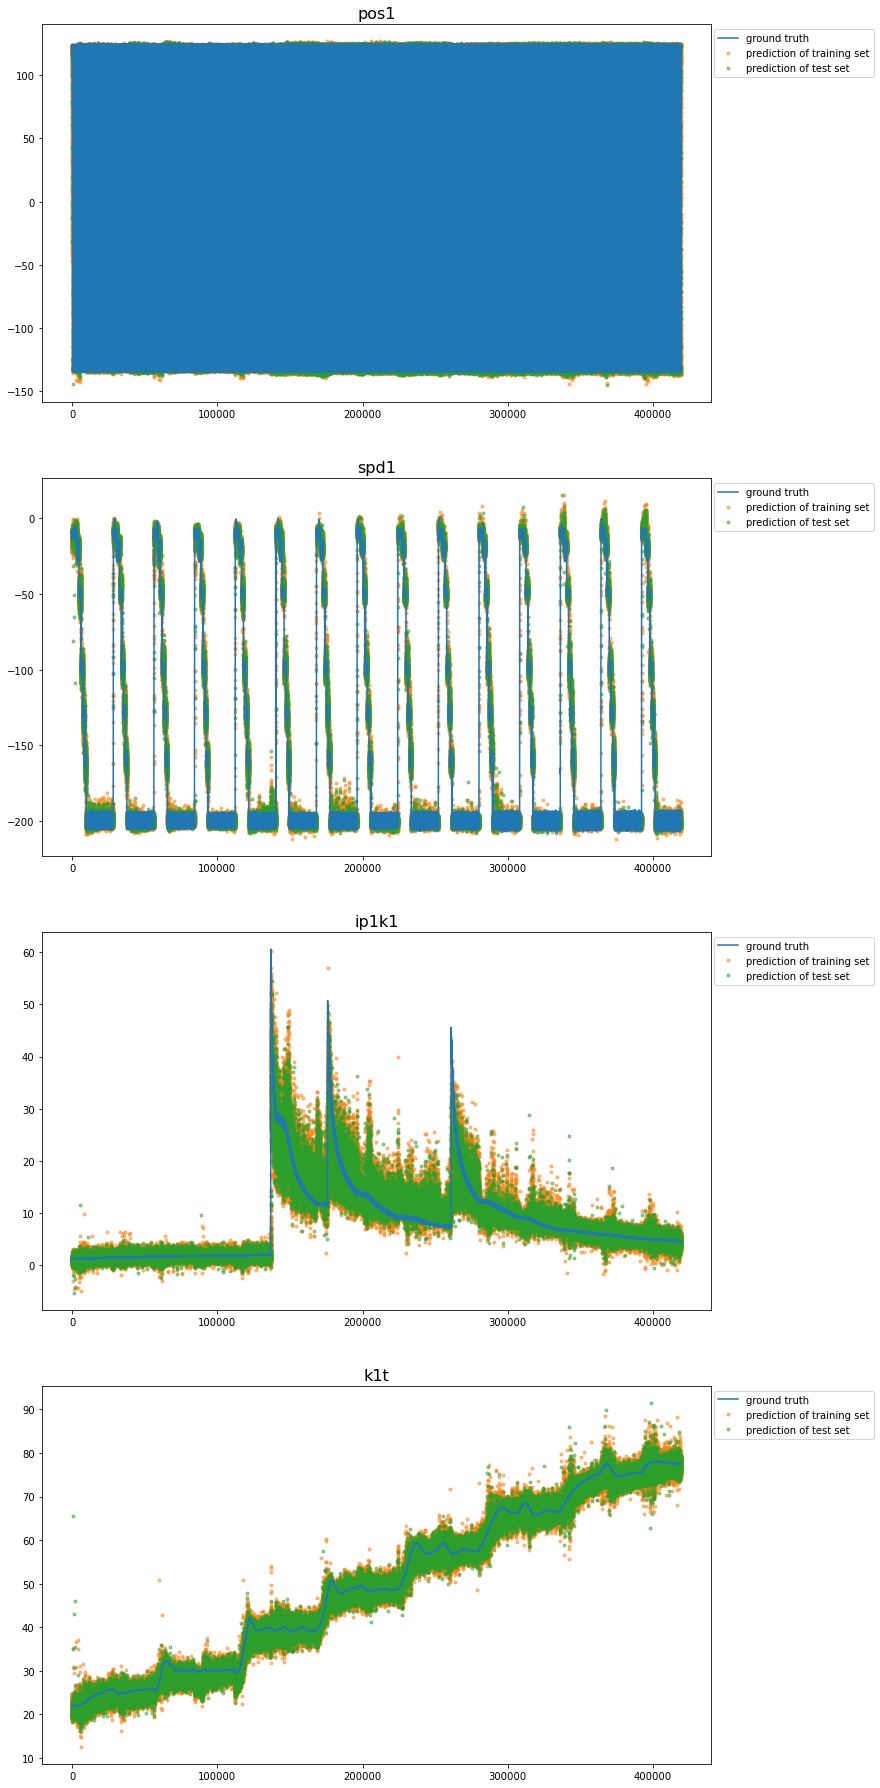

In [28]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### Model of Previous Project

In [59]:
MODEL_NAME = "NN_pp_combi"

In [30]:
normalizer = preprocessing.Normalization()
normalizer.adapt(X_train)
# print(normalizer.mean.numpy())
# first = np.array(X[:1])
# with np.printoptions(precision=2, suppress=True):
#   print('First example:', first)
#   print()
#   print('Normalized:', normalizer(first).numpy())

In [31]:
def model_pp(norm):
  model = keras.Sequential([
      norm,
      # layers.Dense(242, input_dim=242, kernel_initializer='normal', activation='relu'),
      layers.Dense(100, input_dim=242, kernel_initializer='normal',activation='relu'),
      layers.Dense(4,activation='linear')
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

In [32]:
NN_pp= model_pp(normalizer)
NN_pp.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_1 (Normalizati (None, 242)               485       
_________________________________________________________________
dense_3 (Dense)              (None, 100)               24300     
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 404       
Total params: 25,189
Trainable params: 24,704
Non-trainable params: 485
_________________________________________________________________


In [33]:
%%time
history = NN_pp.fit(
    X_train, y_train, batch_size = 64,
    validation_split = 0.125,
    verbose=0, epochs=100)

Wall time: 7min 24s


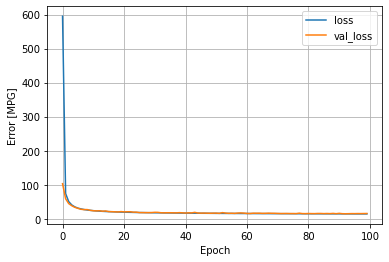

In [34]:
plot_loss(history)

In [35]:
NN_pp.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barNN_pp_combi\assets


In [60]:
# MODEL_NAME = "NN_pp_combi" 
# NN_pp = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [61]:
# evaluation on both training and test sets

y_ = NN_pp.predict(X)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [62]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.431136,4.532848
1,spd1,30.329344,32.627164
2,ip1k1,18.447680,18.701788
3,k1t,5.102790,5.339393


In [63]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  14.577737563315837
MSE of the prediction on test set:  15.300298557148995


In [64]:
print("Evaluations on lsa")
idx_com_train = np.intersect1d(idx_train_sort, low)
idx_com_test = np.intersect1d(idx_test_sort, low)
y_train_lsa_ = y_[idx_com_train]
y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on training set and lsa' : np.mean(np.square(y[idx_com_train] - y_train_lsa_), axis=0),
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa


,Output,MSE of predictions on training set and lsa,MSE of predictions on test set and lsa
0,pos1,3.590551,4.102205
1,spd1,32.450482,36.502990
2,ip1k1,12.538808,12.660414
3,k1t,5.973642,6.364659


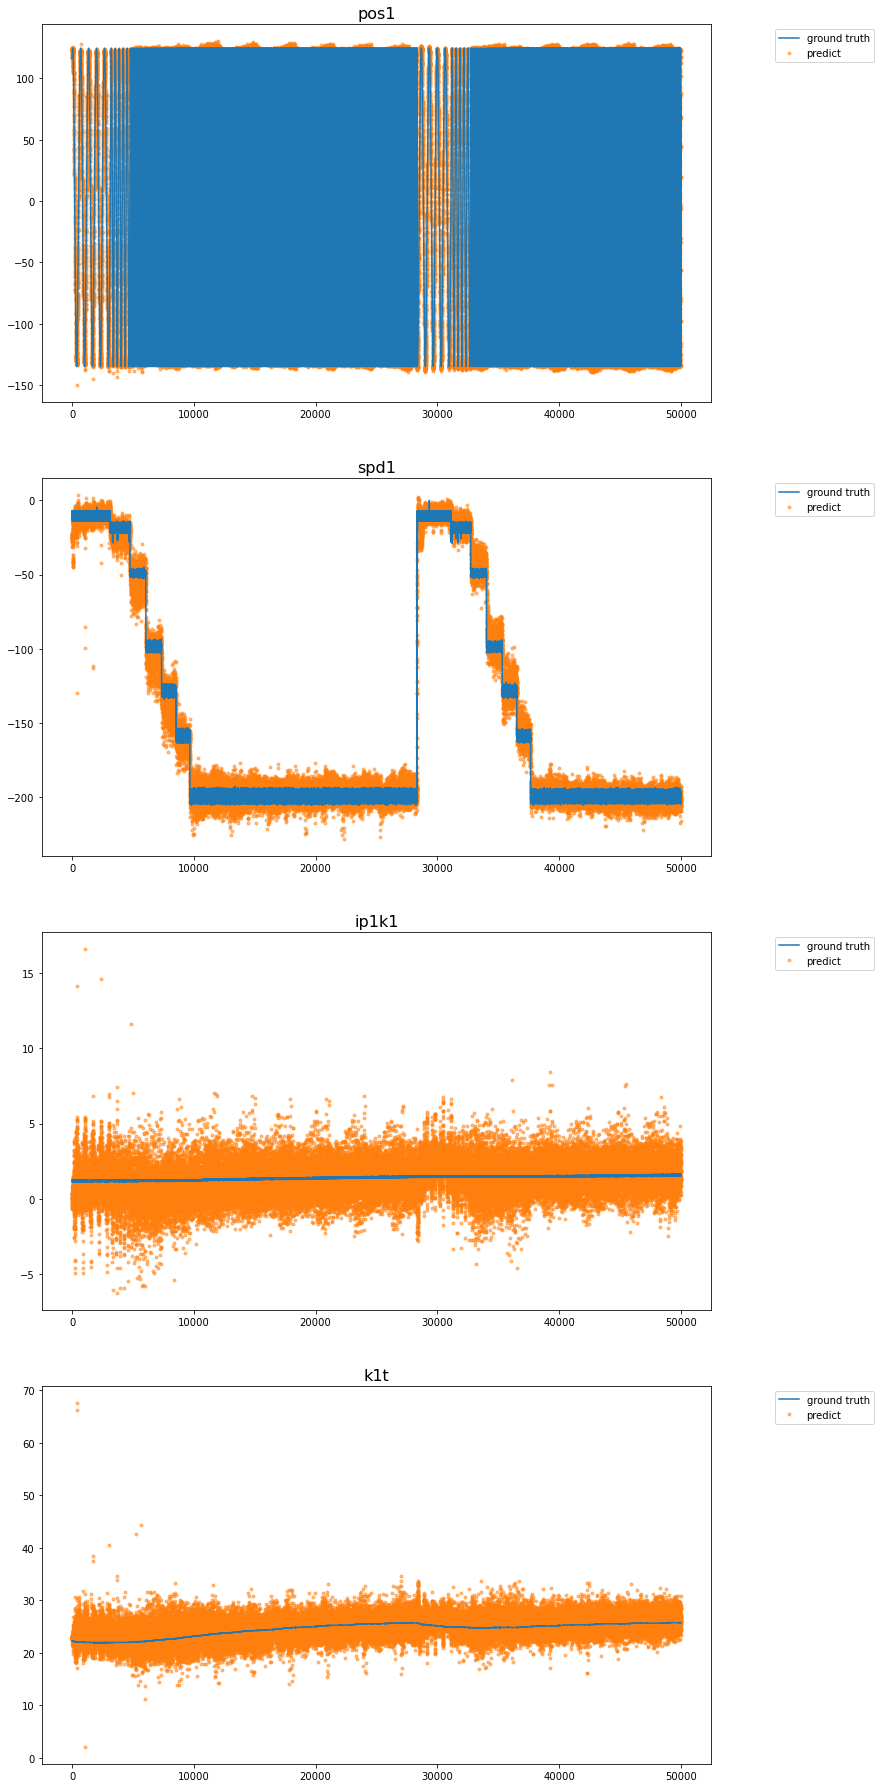

In [65]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

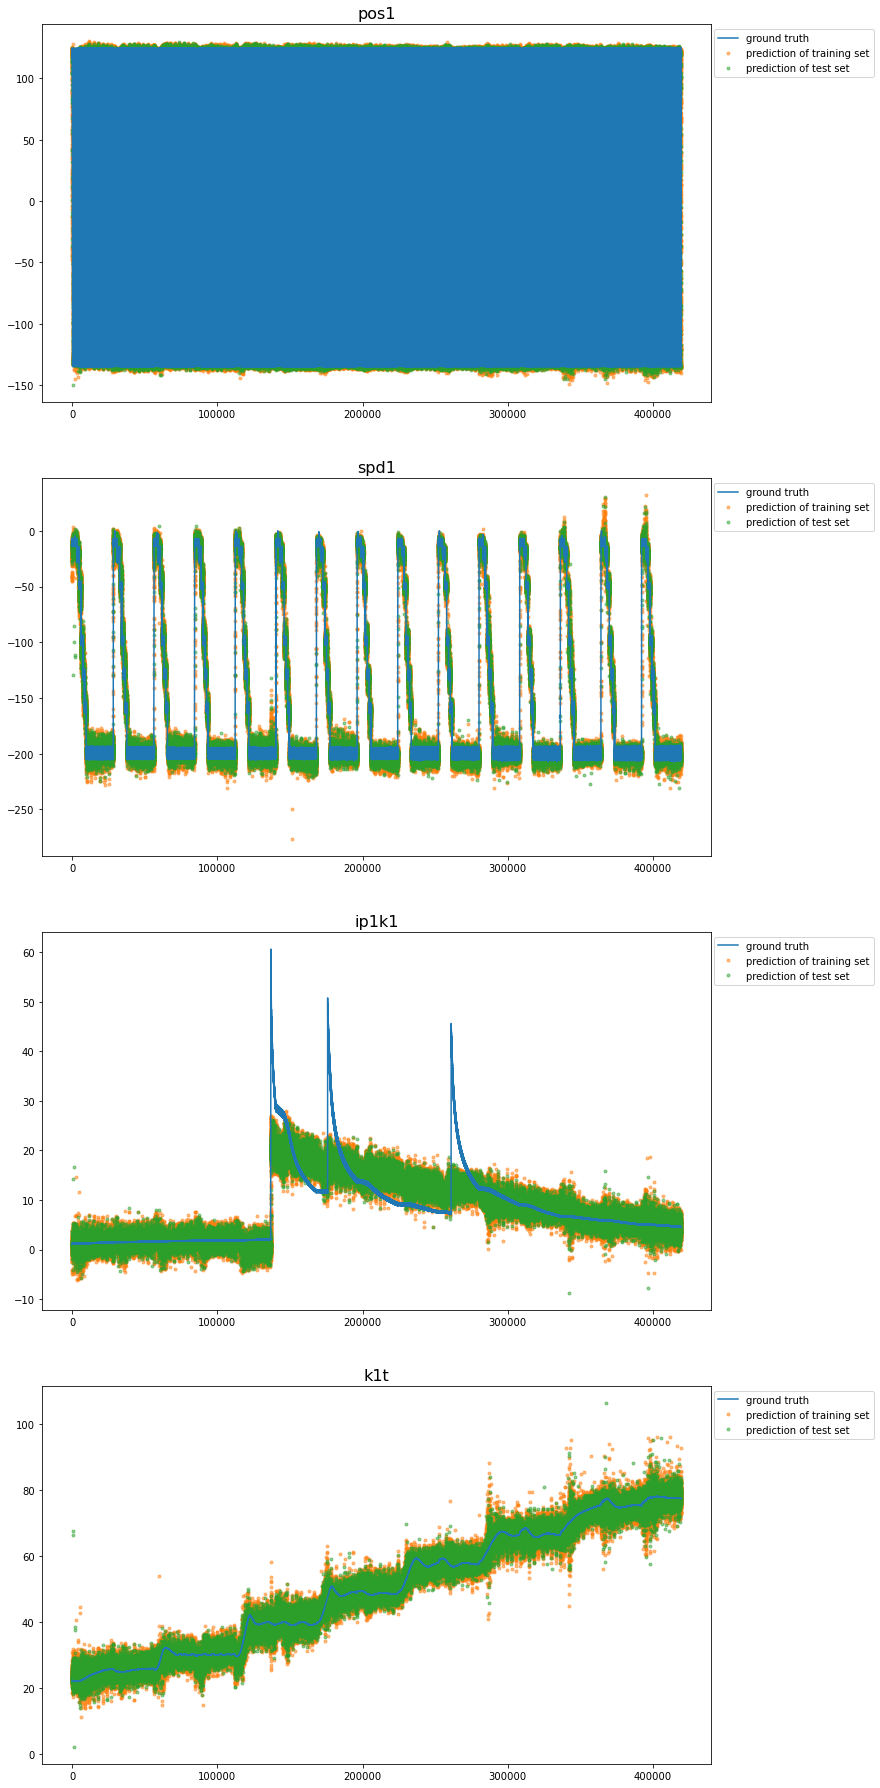

In [66]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### CNN baseline

Conv1D layer expects input shape in 3D as 

**[batch_size, time_steps, input_dimension]**

However, current data is in the shape of 

**[batch_size, features]**

In [41]:
MODEL_NAME = "CNN_baseline_combi"

In [42]:
# normalisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [43]:
# reshape data
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X_train_reshaped = X_train_scaled.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],time_steps,input_dimension)

In [44]:
n_timesteps = X_train_reshaped.shape[1] # 242
n_features  = X_train_reshaped.shape[2] # 1
n_outputs = y_train.shape[1]
def baseline_cnn_model():
  model = keras.Sequential([
      layers.Input(shape=(n_timesteps,n_features)),
      layers.Conv1D(filters=64, kernel_size=7, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=32, kernel_size=5, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(n_outputs)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

CNN = baseline_cnn_model()
CNN.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 236, 64)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 118, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 114, 32)           10272     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 432)              

In [45]:
%%time
history = CNN.fit(
    X_train_reshaped, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Epoch 1/100
4192/4192 - 19s - loss: 383.7937 - val_loss: 93.5437
Epoch 2/100
4192/4192 - 11s - loss: 75.1725 - val_loss: 58.0393
Epoch 3/100
4192/4192 - 11s - loss: 49.9461 - val_loss: 56.9278
Epoch 4/100
4192/4192 - 11s - loss: 39.5673 - val_loss: 39.0271
Epoch 5/100
4192/4192 - 11s - loss: 33.5944 - val_loss: 28.9924
Epoch 6/100
4192/4192 - 11s - loss: 29.8126 - val_loss: 28.6523
Epoch 7/100
4192/4192 - 11s - loss: 27.1559 - val_loss: 28.6442
Epoch 8/100
4192/4192 - 11s - loss: 25.1504 - val_loss: 25.3525
Epoch 9/100
4192/4192 - 11s - loss: 23.7244 - val_loss: 23.3994
Epoch 10/100
4192/4192 - 11s - loss: 22.5945 - val_loss: 21.4724
Epoch 11/100
4192/4192 - 11s - loss: 21.6369 - val_loss: 24.6690
Epoch 12/100
4192/4192 - 11s - loss: 20.7596 - val_loss: 19.7145
Epoch 13/100
4192/4192 - 11s - loss: 20.0544 - val_loss: 19.4644
Epoch 14/100
4192/4192 - 11s - loss: 19.3317 - val_loss: 20.6678
Epoch 15/100
4192/4192 - 11s - loss: 18.8765 - val_loss: 19.5992
Epoch 16/100
4192/4192 - 11s - lo

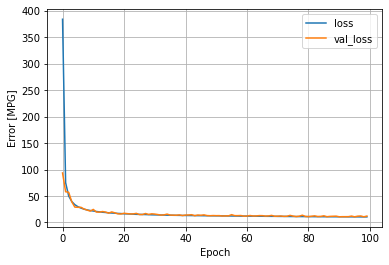

In [46]:
plot_loss(history)

In [47]:
CNN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barCNN_baseline_combi\assets


In [48]:
# MODEL_NAME = "CNN_baseline_combi"
# CNN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [49]:
# Collect the results on the test set
CNN.evaluate(X_test_reshaped, y_test,verbose = 2)

2621/2621 - 5s - loss: 12.0374


12.037371635437012

In [50]:
X_ = scaler.transform(X)
X_ = X_.reshape(X_.shape[0],time_steps,input_dimension)
y_ = CNN.predict(X_)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [51]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,3.299900,3.435915
1,spd1,21.199656,22.904640
2,ip1k1,15.902784,16.520215
3,k1t,5.133237,5.288707


In [52]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low)

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on test set and lsa
0,pos1,2.534860
1,spd1,36.242474
2,ip1k1,10.590631
3,k1t,5.471796


In [53]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  11.383894222444706
MSE of the prediction on test set:  12.03736916641555


Those are the results on training set:


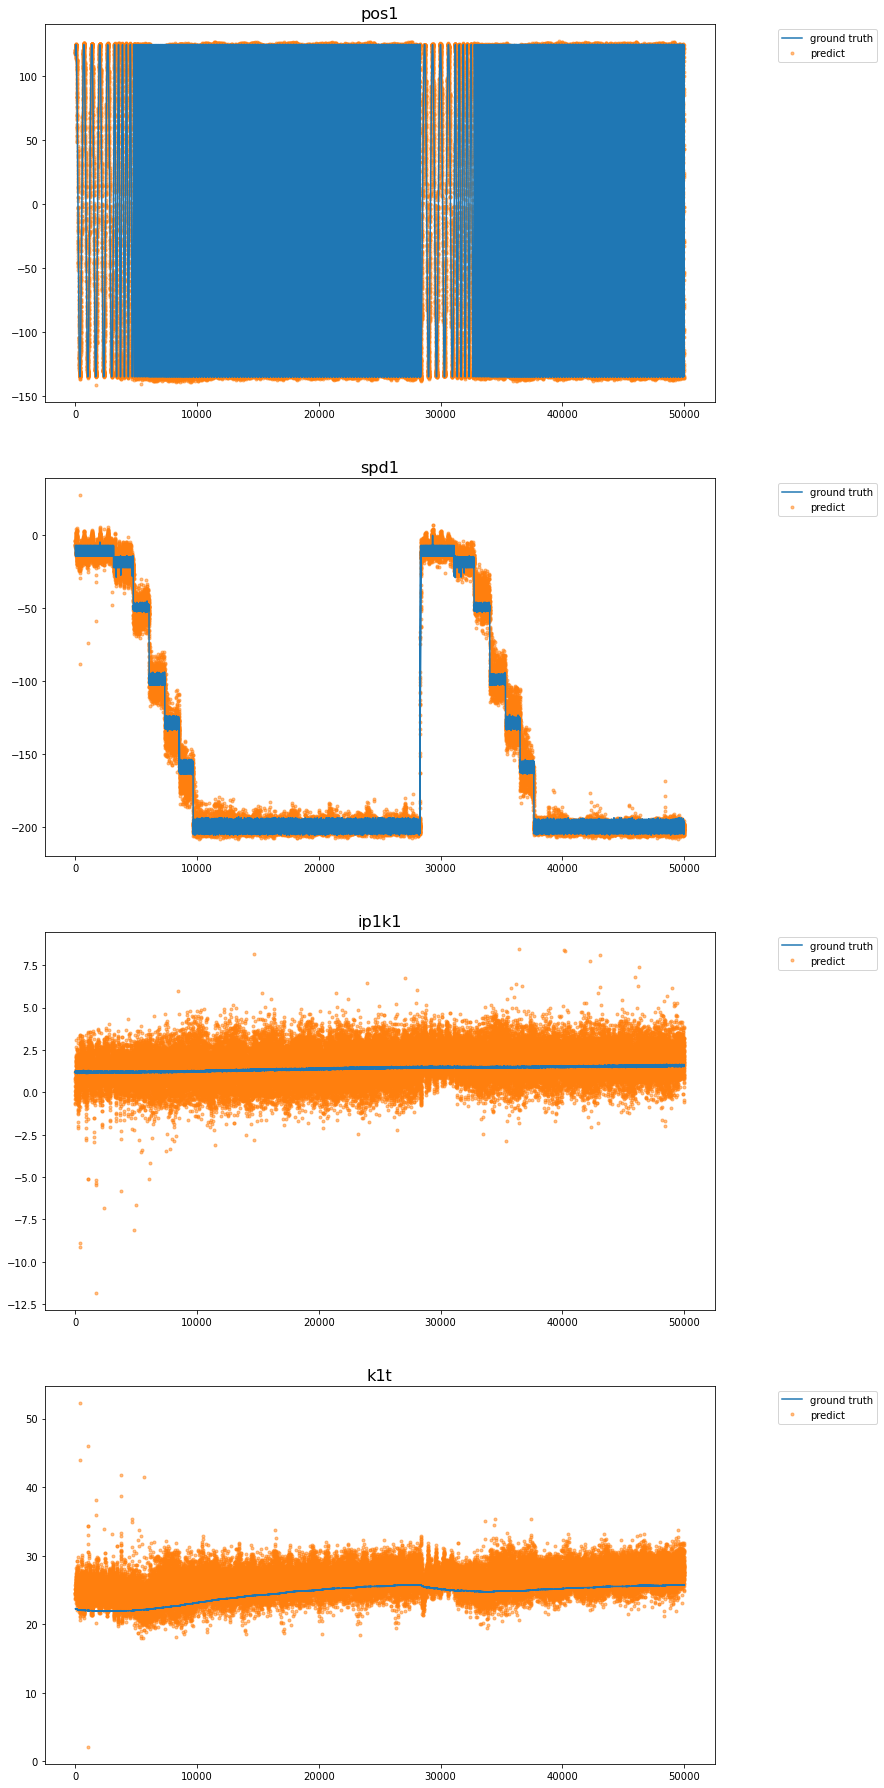

In [54]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
print("Those are the results on training set:")
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

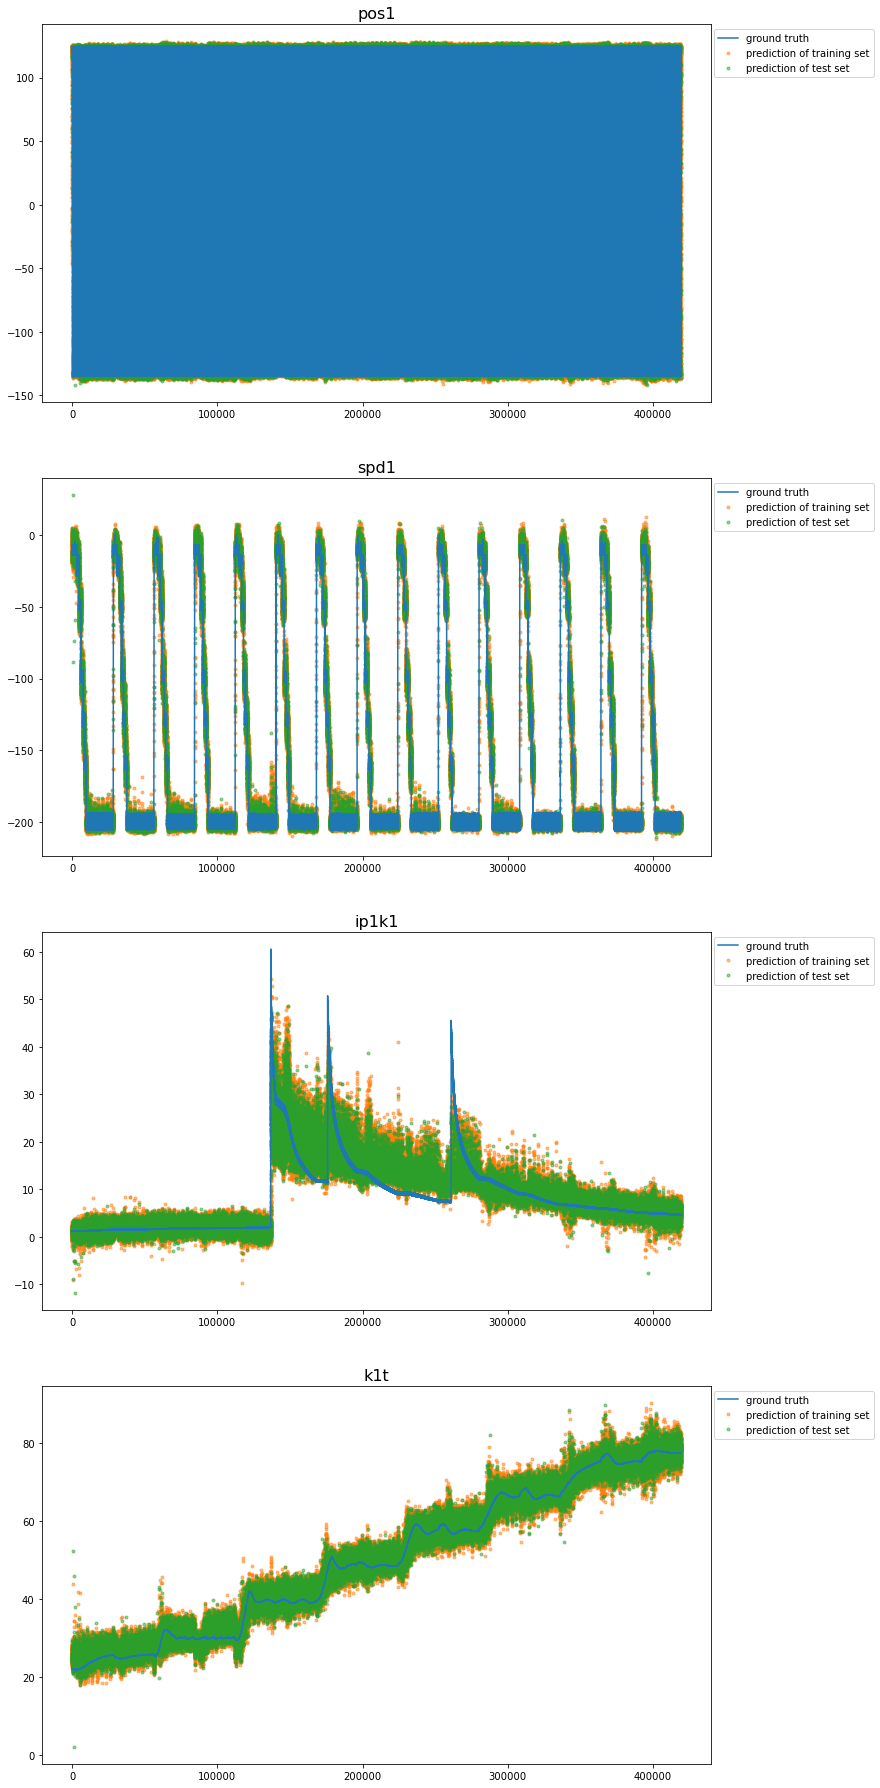

In [55]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)

### CNN tuning

In [12]:
MODEL_NAME = "CNN_tuning_combi"

In [13]:
# normalisation
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
# X_val_scaled = scaler.transform(X_val)
scaler.mean_.shape

(242,)

In [14]:
# reshape data
sample_size = X_train_scaled.shape[0] # number of samples in train set
time_steps  = X_train_scaled.shape[1] # number of features in train set
input_dimension = 1               # each feature is represented by 1 number
X_train_reshaped = X_train_scaled.reshape(sample_size,time_steps,input_dimension)
X_test_reshaped = X_test_scaled.reshape(X_test_scaled.shape[0],time_steps,input_dimension)

In [15]:
n_timesteps = X_train_reshaped.shape[1] # 242
n_features  = X_train_reshaped.shape[2] # 1
n_outputs = y_train.shape[1]
def baseline_cnn_model():
  model = keras.Sequential([
      layers.Input(shape=(n_timesteps,n_features)),
      
        layers.Conv1D(filters=64, kernel_size=10, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=32, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
      layers.MaxPooling1D(pool_size=2),
      layers.Flatten(),
      layers.Dense(64, activation='relu'),
      layers.Dense(n_outputs)
  ])

  model.compile(loss='mean_squared_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

CNN = baseline_cnn_model()
CNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 233, 64)           704       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 116, 64)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 114, 32)           6176      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 57, 32)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 55, 16)            1552      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 27, 16)            0         
_________________________________________________________________
flatten (Flatten)            (None, 432)               0

In [16]:
%%time
history = CNN.fit(
    X_train_reshaped, y_train, batch_size = 64,
    validation_split=0.2,
    verbose=0, epochs=100)

Epoch 1/100
4192/4192 - 15s - loss: 347.1643 - val_loss: 101.2929
Epoch 2/100
4192/4192 - 11s - loss: 67.8982 - val_loss: 58.6389
Epoch 3/100
4192/4192 - 12s - loss: 47.7762 - val_loss: 43.6215
Epoch 4/100
4192/4192 - 11s - loss: 38.1274 - val_loss: 53.8634
Epoch 5/100
4192/4192 - 11s - loss: 32.6035 - val_loss: 33.6504
Epoch 6/100
4192/4192 - 11s - loss: 29.1145 - val_loss: 26.6457
Epoch 7/100
4192/4192 - 12s - loss: 26.4831 - val_loss: 24.0594
Epoch 8/100
4192/4192 - 11s - loss: 24.5662 - val_loss: 24.7769
Epoch 9/100
4192/4192 - 11s - loss: 23.1976 - val_loss: 25.1590
Epoch 10/100
4192/4192 - 11s - loss: 21.8340 - val_loss: 20.1938
Epoch 11/100
4192/4192 - 11s - loss: 20.8249 - val_loss: 20.5864
Epoch 12/100
4192/4192 - 11s - loss: 20.0291 - val_loss: 20.3901
Epoch 13/100
4192/4192 - 11s - loss: 19.2781 - val_loss: 19.9890
Epoch 14/100
4192/4192 - 11s - loss: 18.7060 - val_loss: 20.8197
Epoch 15/100
4192/4192 - 11s - loss: 18.0747 - val_loss: 18.4414
Epoch 16/100
4192/4192 - 11s - l

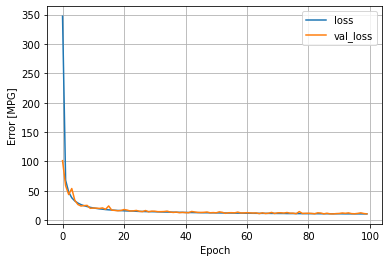

In [17]:
plot_loss(history)

In [18]:
CNN.save(os.path.join(SAVED_IN, MODEL_NAME))

INFO:tensorflow:Assets written to: C:\Users\xin\OneDrive - bwstaff\xin\trelleborg\models\V27\100barCNN_tuning\assets


In [19]:
# MODEL_NAME = "CNN_tuning_combi"
# CNN = tf.keras.models.load_model(os.path.join(SAVED_IN, MODEL_NAME))

In [20]:
# Collect the results on the test set
CNN.evaluate(X_test_reshaped, y_test,verbose = 2)

2621/2621 - 5s - loss: 10.7670


10.767005920410156

In [21]:
X_ = scaler.transform(X)
X_ = X_.reshape(X_.shape[0],time_steps,input_dimension)
y_ = CNN.predict(X_)
y_train_ = y_[idx_train_sort].squeeze()
y_test_ =y_[idx_test_sort].squeeze()

In [22]:
err_dict = {
    'Output':GT,
    'MSE of predictions on training set' : np.mean(np.square(y[idx_train_sort] - y_train_), axis=0),
    'MSE of predictions on test set' : np.mean(np.square(y[idx_test_sort] - y_test_), axis=0)
}
df = pd.DataFrame.from_dict(err_dict)
df

,Output,MSE of predictions on training set,MSE of predictions on test set
0,pos1,4.437064,4.537566
1,spd1,17.282855,19.047377
2,ip1k1,14.712796,15.261701
3,k1t,4.046593,4.221469


In [23]:
print("Evaluations on lsa of the last dataset")

idx_com_test = np.intersect1d(idx_test_sort, low)

y_test_lsa_ = y_[idx_com_test]
err_dict_lsa = {
    'Output':GT,
    'MSE of predictions on test set and lsa' : np.mean(np.square(y[idx_com_test] - y_test_lsa_), axis=0)
}
df_lsa = pd.DataFrame.from_dict(err_dict_lsa)
df_lsa

Evaluations on lsa of the last dataset


,Output,MSE of predictions on test set and lsa
0,pos1,3.182772
1,spd1,27.825454
2,ip1k1,8.969740
3,k1t,4.766737


In [24]:
from sklearn.metrics import mean_squared_error
print ("MSE of the prediction on training set: ", mean_squared_error(y_train_,y[idx_train_sort]))
print ("MSE of the prediction on test set: ", mean_squared_error(y_test_,y[idx_test_sort]))

MSE of the prediction on training set:  10.119827329328032
MSE of the prediction on test set:  10.767028208060836


Those are the results on training set:


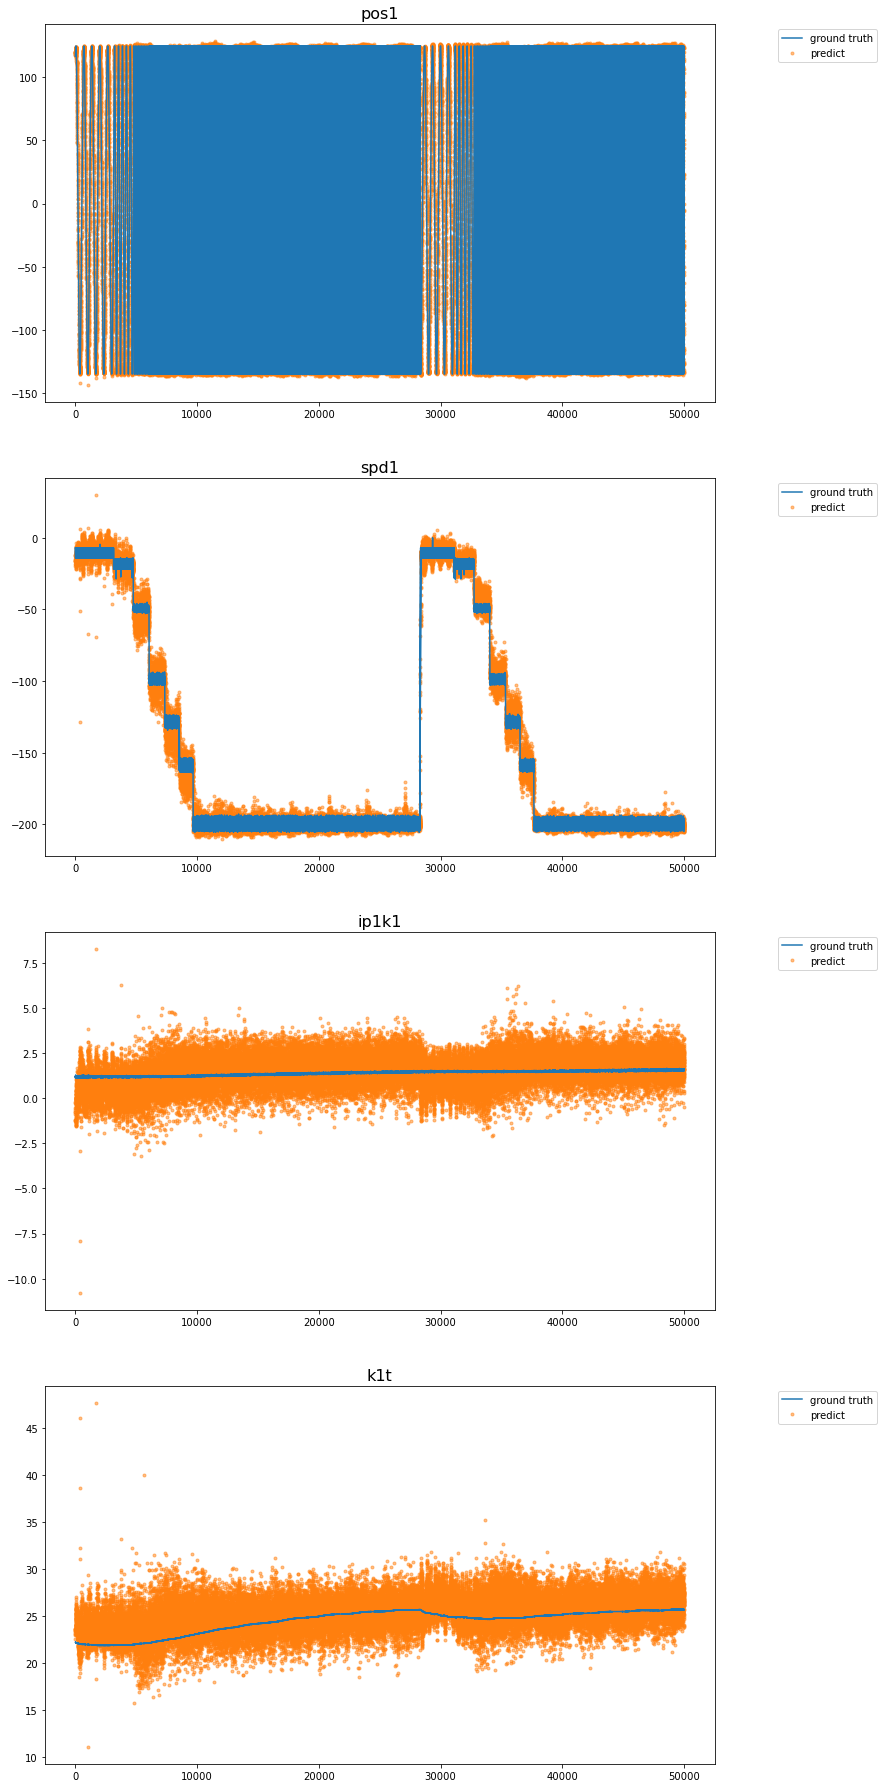

In [25]:
#   predictioin vs ground truth in one plot
#   for multiple outputs (with names listed in the argument "outputs") in one plot
#   with only first 50000 points"""
print("Those are the results on training set:")
%matplotlib inline
plot_gt_pre_overlap_mul(y,y_,GT)

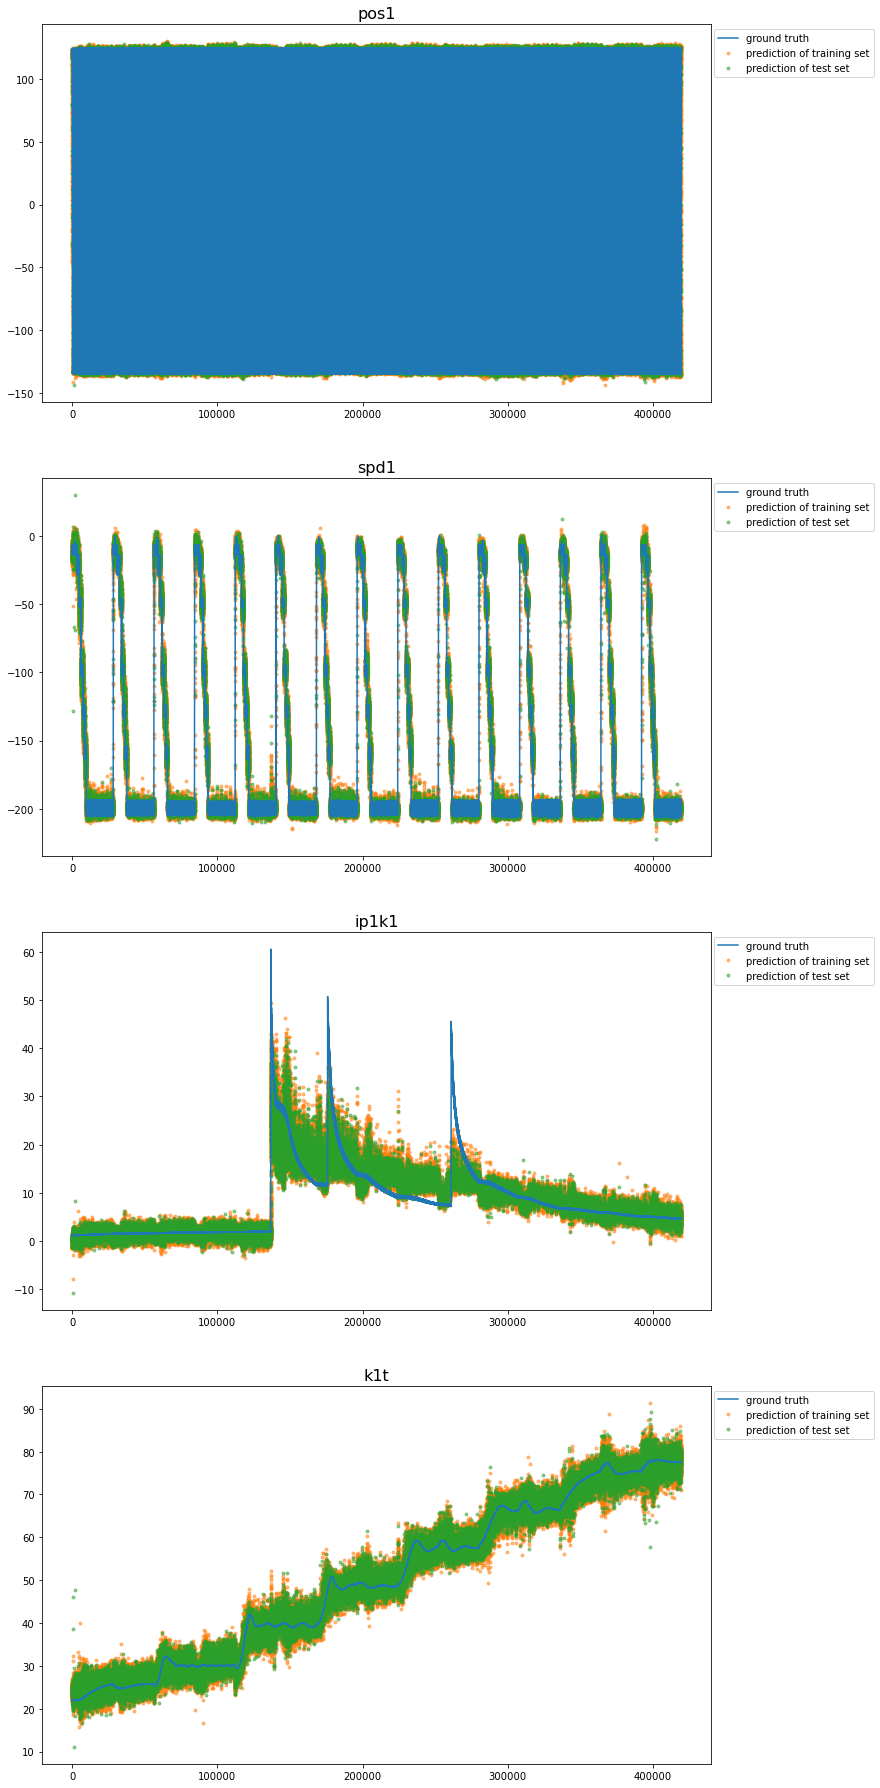

In [26]:
# (predictioin for X_test and X_train separately) vs (ground truth)  
# for multiple outputs (with names listed in the argument "outputs") in one plot
%matplotlib inline
plot_gt_pre_sep_mul(y,idx_train_sort,y_train_,idx_test_sort,y_test_,GT)